In [84]:
import matplotlib as mpl
import pandas as pd
import wmfdata as wmf

from wmfdata.utils import pd_display_all

In [63]:
wmf.charting.set_mpl_style()

# Names of all Elizabeth II articles

The CSV comes from the following SPARQL query on Wikidata:
```
SELECT DISTINCT ?url ?name WHERE {
  ?article schema:about wd:Q9682 . hint:Prior hint:runFirst true.
  ?article schema:isPartOf ?url ;
    schema:name ?name ;
    schema:isPartOf [ wikibase:wikiGroup "wikipedia" ] .
}
```

In [5]:
elizabeth_ii_articles = pd.read_csv("~/elizabeth_ii_articles.csv")
elizabeth_ii_articles.head()

,url,name
0,https://km.wikipedia.org/,សម្តេចព្រះរាជិនីនាថអេលីហ្សាបិតទី ២ នៃសហរាជាណាចក្រ
1,https://kcg.wikipedia.org/,A̱li̱za̱ba̱t II
2,https://bs.wikipedia.org/,Elizabeta II
3,https://wuu.wikipedia.org/,伊丽莎白两世
4,https://na.wikipedia.org/,Elizabeth II


In [6]:
elizabeth_ii_articles["url"] = (
    elizabeth_ii_articles["url"]
    .str.replace("https://", "")
    .str.replace("/", "")
)

elizabeth_ii_articles.head()

,url,name
0,km.wikipedia.org,សម្តេចព្រះរាជិនីនាថអេលីហ្សាបិតទី ២ នៃសហរាជាណាចក្រ
1,kcg.wikipedia.org,A̱li̱za̱ba̱t II
2,bs.wikipedia.org,Elizabeta II
3,wuu.wikipedia.org,伊丽莎白两世
4,na.wikipedia.org,Elizabeth II


In [7]:
elizabeth_ii_articles.to_csv("~/elizabeth_ii_articles.csv", index=False)

In [9]:
wmf.hive.load_csv(
    "/home/neilpquinn-wmf/elizabeth_ii_articles.csv",
    "project_url STRING, article_title STRING",
    "nshahquinn",
    "elizabeth_ii_articles"
)

In [10]:
wmf.presto.run("""
SELECT *
FROM nshahquinn.elizabeth_ii_articles
LIMIT 10
""")

,project_url,article_title
0,km.wikipedia.org,សម្តេចព្រះរាជិនីនាថអេលីហ្សាបិតទី ២ នៃសហរាជាណាចក្រ
1,kcg.wikipedia.org,A̱li̱za̱ba̱t II
2,bs.wikipedia.org,Elizabeta II
3,wuu.wikipedia.org,伊丽莎白两世
4,na.wikipedia.org,Elizabeth II
5,arc.wikipedia.org,ܐܠܝܙܒܬ ܬܪܝܢܝܬܐ
6,zea.wikipedia.org,Elizabeth II
7,ny.wikipedia.org,Elizabeth II
8,mt.wikipedia.org,Eliżabetta II
9,fiu-vro.wikipedia.org,Kuningaimänd Elizabeth II


# Daily views to Elizabeth II articles

In [68]:
article_views = wmf.spark.run("""
SELECT
    project_url,
    article_title,
    SUM(view_count) AS views
FROM nshahquinn.elizabeth_ii_articles ea
LEFT JOIN wmf.pageview_hourly ph
ON
    REPLACE(ea.project_url, '.org', '') = ph.project
    AND REPLACE(ea.article_title, ' ', '_') = ph.page_title
WHERE
    agent_type = 'user'
    AND year = 2022
    AND month = 9
    AND day = 8
GROUP BY
    project_url,
    article_title
""")

PySpark executors will use /usr/lib/anaconda-wmf/bin/python3.


In [75]:
article_views["views"].sum()

19862035

In [74]:
article_views.sort_values("views",  ascending=False)

,project_url,article_title,views
100,en.wikipedia.org,Elizabeth II,8399082
21,es.wikipedia.org,Isabel II del Reino Unido,2854772
91,ru.wikipedia.org,Елизавета II,1490433
96,fr.wikipedia.org,Élisabeth II,1106956
94,it.wikipedia.org,Elisabetta II del Regno Unito,919857
...,...,...,...
142,sd.wikipedia.org,ايلزبٿ ٻين (برطانيا),13
57,nrm.wikipedia.org,Lîzabé II du Rouoyaume Unni,13
154,ilo.wikipedia.org,Isabel II,12
66,bh.wikipedia.org,एलिजाबेथ II,12


In [71]:
article_views.sort_values("views", ascending=False).head(10)

,project_url,article_title,views
100,en.wikipedia.org,Elizabeth II,8399082
21,es.wikipedia.org,Isabel II del Reino Unido,2854772
91,ru.wikipedia.org,Елизавета II,1490433
96,fr.wikipedia.org,Élisabeth II,1106956
94,it.wikipedia.org,Elisabetta II del Regno Unito,919857
108,de.wikipedia.org,Elisabeth II.,850781
79,pl.wikipedia.org,Elżbieta II,776423
68,pt.wikipedia.org,Isabel II do Reino Unido,605123
1,ar.wikipedia.org,إليزابيث الثانية,488324
58,fa.wikipedia.org,الیزابت دوم,260660


# Minute-by-minute traffic spike

In [35]:
# Hack for convenient reading of numeric tables
pd.set_eng_float_format(accuracy=0, use_eng_prefix=True)

In [39]:
%%time
wp_pv_minutely_r = wmf.spark.run(
    """
    SELECT
        DATE_TRUNC('MINUTE', TO_TIMESTAMP(dt)) AS minute,
        COUNT(1) AS views
    FROM wmf.pageview_actor
    WHERE
        agent_type = 'user'
        AND is_pageview
        AND normalized_host['project_family'] = 'wikipedia'
        AND year = 2022
        AND month = 9
        AND (
            day IN (7, 8)
            OR day = 9 AND hour < 2
        )
    GROUP BY
        DATE_TRUNC('MINUTE', TO_TIMESTAMP(dt))
    """,
    session_type="yarn-large"
)

PySpark executors will use /usr/lib/anaconda-wmf/bin/python3.


CPU times: user 503 ms, sys: 79.4 ms, total: 583 ms
Wall time: 1min 39s


22/09/09 03:01:42 WARN TransportChannelHandler: Exception in connection from /10.64.5.31:40920
java.io.IOException: Connection reset by peer
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledUnsafeDirectByteBuf.setBytes(PooledUnsafeDirectByteBuf.java:288)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1106)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:343)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:123)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:645)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:580)
	at io.netty.channel.nio.NioEventLoop.processSel

In [48]:
wp_pv_minutely = wp_pv_minutely_r.dropna().sort_values("minute").reset_index(drop=True)

In [49]:
wp_pv_minutely

,minute,views
0,2022-09-07 00:00:00,261009
1,2022-09-07 00:01:00,262827
2,2022-09-07 00:02:00,265982
3,2022-09-07 00:03:00,264300
4,2022-09-07 00:04:00,262477
...,...,...
2995,2022-09-09 01:55:00,334222
2996,2022-09-09 01:56:00,334734
2997,2022-09-09 01:57:00,331668
2998,2022-09-09 01:58:00,330603


In [58]:
(
    wp_pv_minutely
    .query("minute >= '2022-09-08 17:30:00' and minute < '2022-09-08 18:00:00'")
    .assign(views=lambda df: df["views"].astype(float))
    .pipe(pd_display_all)
)

,minute,views
2490,2022-09-08 17:30:00,441k
2491,2022-09-08 17:31:00,440k
2492,2022-09-08 17:32:00,451k
2493,2022-09-08 17:33:00,492k
2494,2022-09-08 17:34:00,543k
2495,2022-09-08 17:35:00,583k
2496,2022-09-08 17:36:00,620k
2497,2022-09-08 17:37:00,659k
2498,2022-09-08 17:38:00,697k
2499,2022-09-08 17:39:00,728k


In [61]:
(
    wp_pv_minutely
    .query("minute >= '2022-09-07 17:30:00' and minute < '2022-09-07 18:00:00'")
    ["views"]
    .mean()
    .round(-3)
)

394000.0

In [102]:
wp_pv_minutely_for_graphing = (
    wp_pv_minutely
    .assign(minute=lambda df: (df["minute"] - pd.Timestamp("1970-01-01")) / pd.Timedelta('1d'))
    .groupby("minute")
    ["views"]
    .sum()
)

## Graphing

NOTE: This is ugly, hacky code written on a time crunch. I will possibly clean it up later.

In [226]:
from matplotlib import font_manager
fm = font_manager.FontManager()
fm.addfont('/home/neilpquinn-wmf/.fonts/Montserrat-Bold.ttf')

In [228]:
fm.findfont('Montserrat')

'/srv/home/neilpquinn-wmf/.fonts/Montserrat-Bold.ttf'

In [224]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'pageviews per minute')

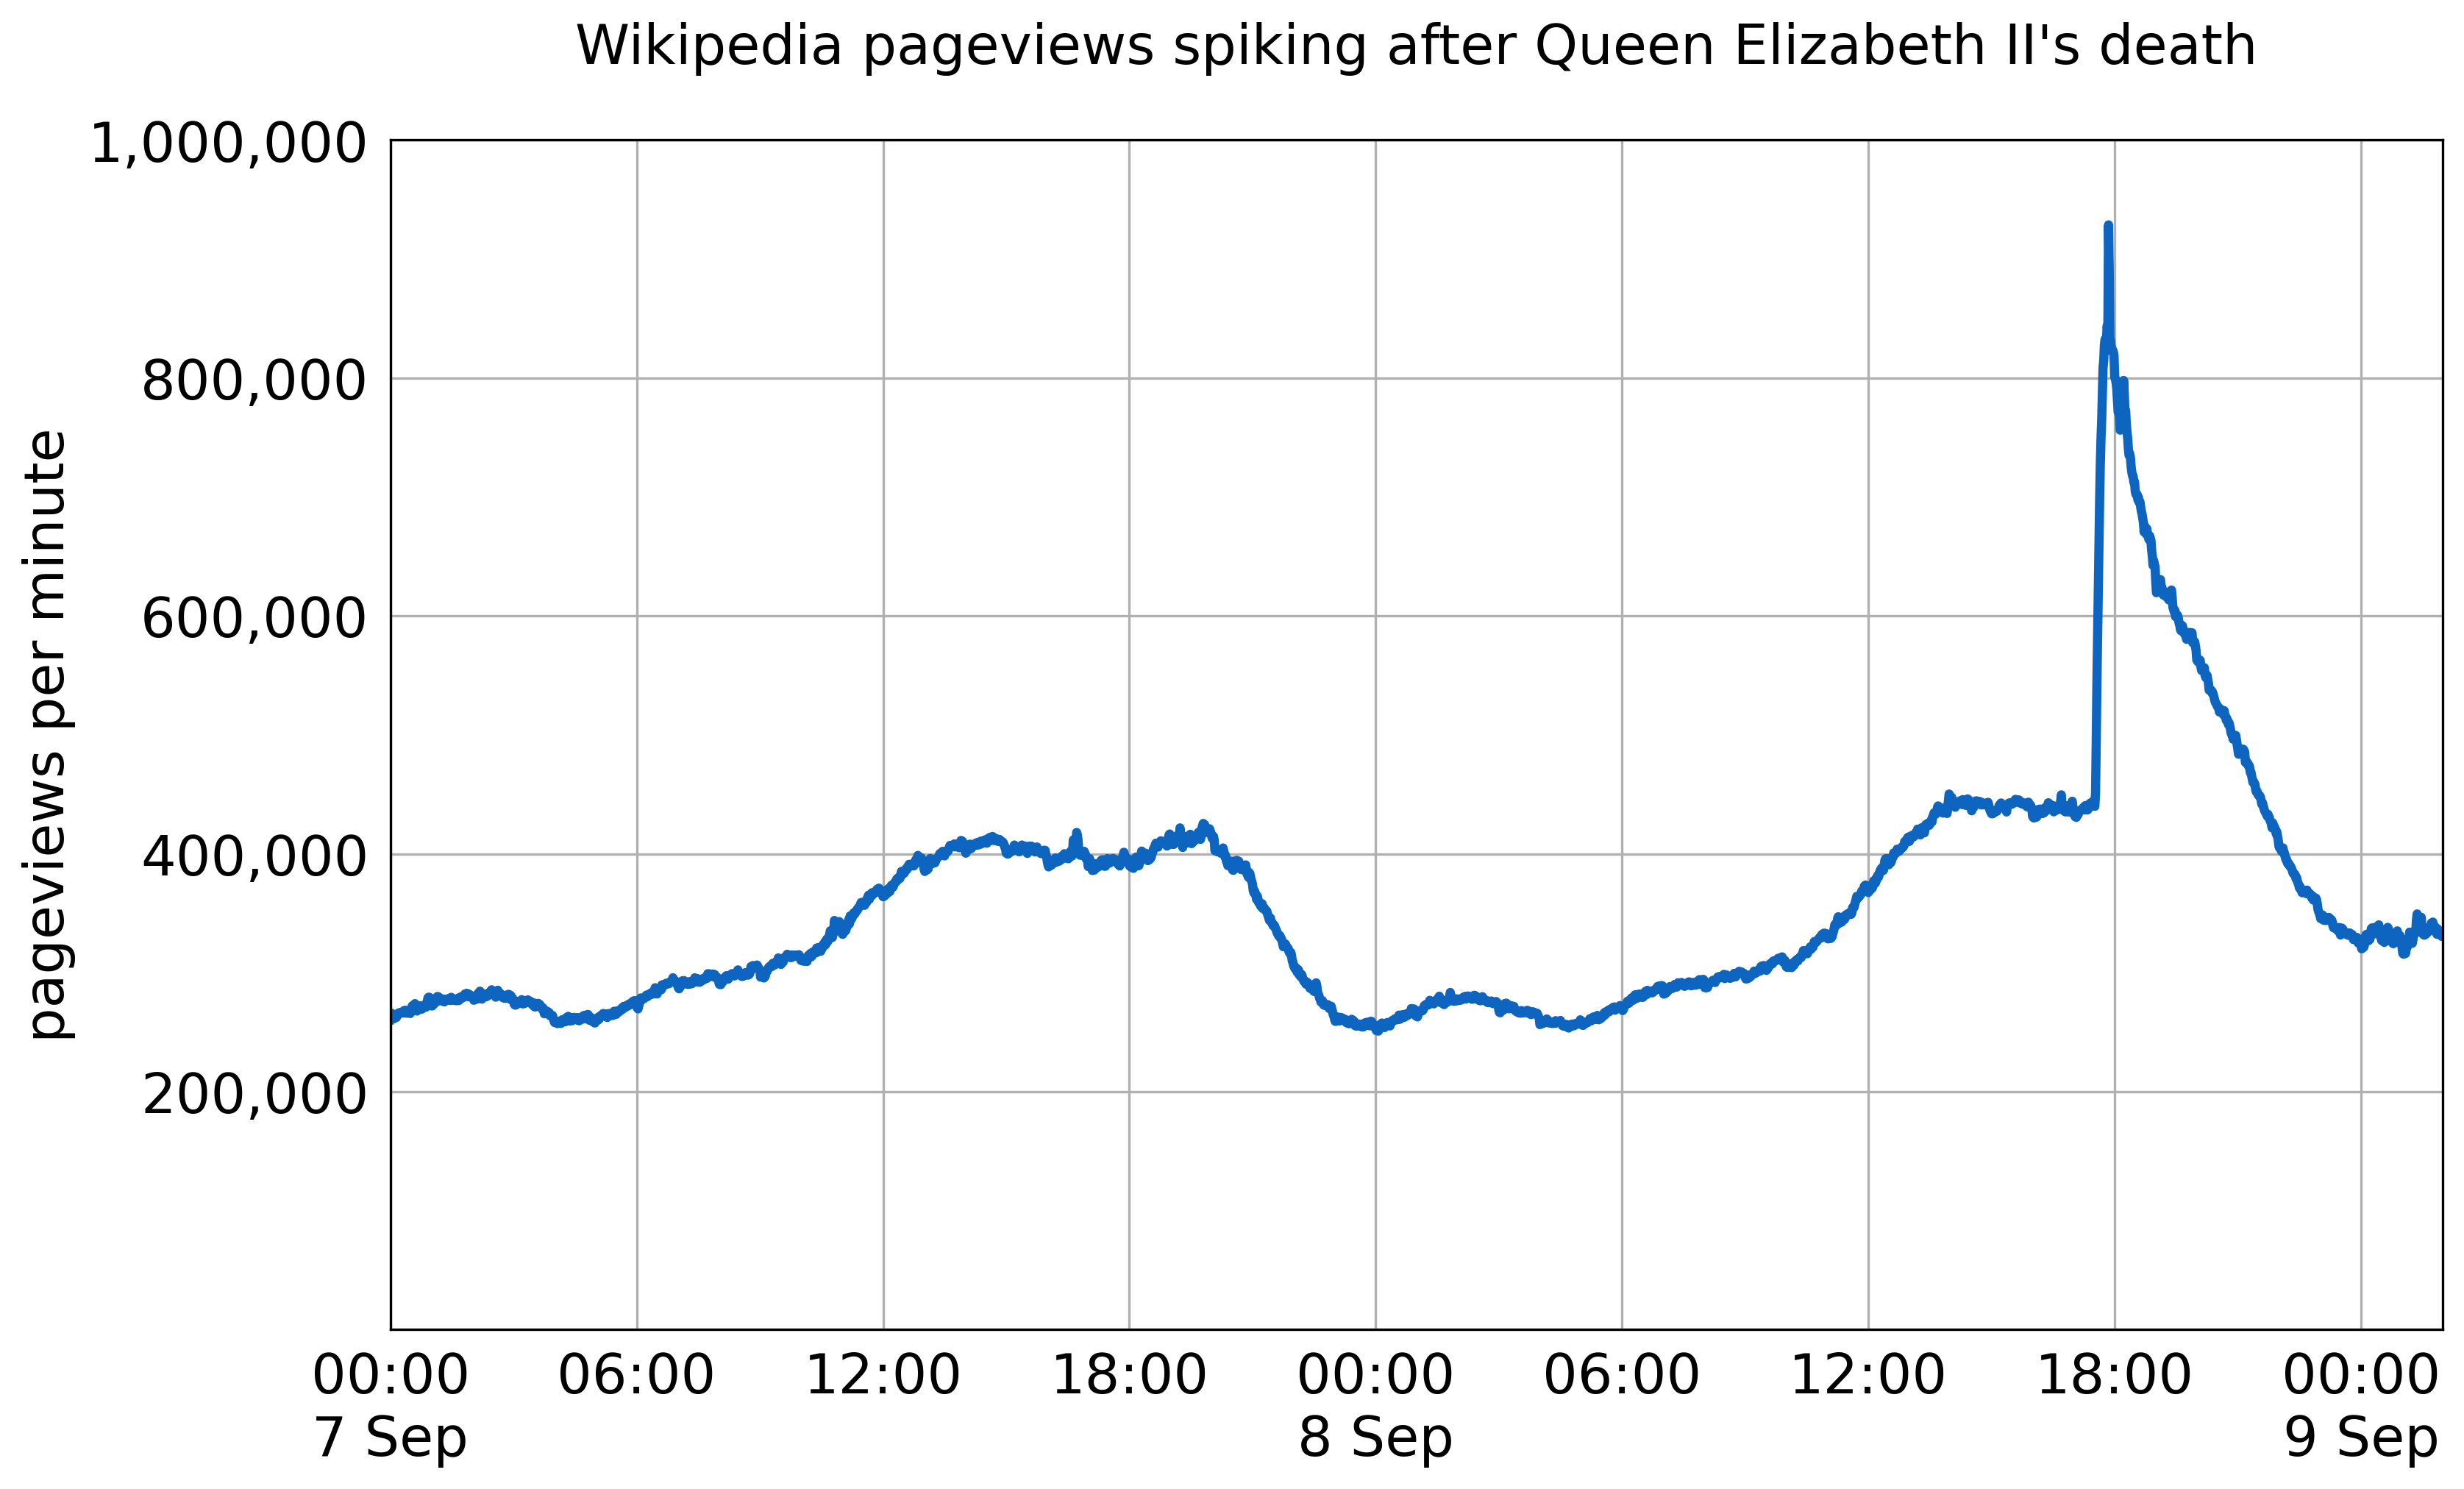

In [238]:
# mpl.rcParams['font.family'] = 'Montserrat'
mpl.rcParams['font.weight'] = "normal"
mpl.rcParams['font.size'] = 18
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['figure.figsize'] = (12, 7)
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0
mpl.rcParams['figure.dpi'] = 300

ax = wp_pv_minutely_for_graphing.plot(ylim=(0, 1000000), color="#0E65C0")

fig = mpl.pyplot.gcf()

locator = mpl.dates.AutoDateLocator()
formatter = mpl.dates.ConciseDateFormatter(locator)
formatter.formats = ['%y',  # ticks are mostly years
                     '%b',       # ticks are mostly months
                     '%d',       # ticks are mostly days
                     '%H:%M',    # hrs
                     '%H:%M',    # min
                     '%S.%f', ]  # secs
# these are mostly just the level above...
formatter.zero_formats = [''] + formatter.formats[:-1]
# ...except for ticks that are mostly hours, then it is nice to have
# month-day:
formatter.zero_formats[3] = '%H:%M\n%-d %b'

formatter.offset_formats = ['',
                            '%Y',
                            '%b %Y',
                            '',
                            '',
                            '%d %b %Y %H:%M', ]
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

def custom_fmt(x, p):
    if x == 0:
        return None
    else:
        return wmf.charting.comma_fmt(x)

ax.yaxis.set_major_formatter(custom_fmt)

ax.set_title("Wikipedia pageviews spiking after Queen Elizabeth II's death", pad=25)
ax.set_xlabel("")
ax.set_ylabel("pageviews per minute")

# plt.savefig("qe2.png", pad_inches=0.3)

Getting the pageviews for today, the previous week, and other previous days that appear to be spikes based on [the siteviews tool](https://pageviews.wmcloud.org/siteviews/), which has an all projects but not all Wikipedias aggregation.

# Daily total traffic in historical context

In [33]:
wp_pv_daily = wmf.spark.run("""
SELECT
    year,
    month,
    day,
    SUM(view_count) AS views
FROM wmf.pageview_hourly
WHERE
    (
        year = 2022 AND month = 9
        OR year = 2022 AND month = 2 AND DAY IN (25, 26, 27, 28)
        OR year = 2021 AND month = 2 AND DAY IN (14, 15, 16)
        OR year = 2020 AND month = 5 AND DAY IN (1, 2, 3, 4, 5)
    )
    AND agent_type = 'user'
    AND project LIKE '%.wikipedia'
GROUP BY
    year,
    month,
    day
ORDER BY
    year,
    month,
    day
""")

PySpark executors will use /usr/lib/anaconda-wmf/bin/python3.


In [36]:
wp_pv_daily.assign(views=lambda df: df["views"].astype(float))

,year,month,day,views
0,2020,5,1,603M
1,2020,5,2,599M
2,2020,5,3,630M
3,2020,5,4,620M
4,2020,5,5,616M
5,2021,2,14,580M
6,2021,2,15,645M
7,2021,2,16,602M
8,2022,2,25,552M
9,2022,2,26,539M


In [37]:
wp_pv_daily.query("month == 9 and day <= 7")["views"].mean().astype(int)

475847813